Import necessary libraries:

In [36]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import BaggingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
import matplotlib.pyplot as plt
import seaborn as snsy
import warnings
warnings.filterwarnings("ignore")


sns.set(rc={'figure.figsize': (11.7, 8.27)})


Load the dataset and evaluate the data:

In [37]:
def evaluate_data(data):
    # Display the first few rows of the data and check for null values
    display(data.head())
    print('Null values:', data.isnull().sum().sum())

    # Display descriptive statistics of the data
    pd.set_option('display.max_columns', None)
    display(data.describe())
    pd.reset_option('display.max_columns')

heart_csv = '../8901541/DataSets/heart.csv'  
heart_data = pd.read_csv(heart_csv)

evaluate_data(heart_data)
print(heart_data['HeartDisease'].value_counts())
print(round(heart_data['HeartDisease'].value_counts()[1] / len(heart_data) * 100, 2), '% pd')


,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


Null values: 0


,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
count,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000
mean,53.510893,132.396514,198.799564,0.233115,136.809368,0.887364,0.553377
std,9.432617,18.514154,109.384145,0.423046,25.460334,1.066570,0.497414
min,28.000000,0.000000,0.000000,0.000000,60.000000,-2.600000,0.000000
25%,47.000000,120.000000,173.250000,0.000000,120.000000,0.000000,0.000000
50%,54.000000,130.000000,223.000000,0.000000,138.000000,0.600000,1.000000
75%,60.000000,140.000000,267.000000,0.000000,156.000000,1.500000,1.000000
max,77.000000,200.000000,603.000000,1.000000,202.000000,6.200000,1.000000


HeartDisease
1    508
0    410
Name: count, dtype: int64
55.34 % pd


Remove outliers using Z-score:

In [38]:
def remove_outliers_zscore(data, z_threshold=3, skip_columns=[]):
    num_removed = {}

    for column in data.columns:
        if column in skip_columns:
            continue

        mean = np.mean(data[column])
        std = np.std(data[column])
        z_scores = np.abs((data[column] - mean) / std)
        outliers = z_scores > z_threshold

        num_outliers_removed = np.sum(outliers)
        num_removed[column] = num_outliers_removed

        data = data[~outliers]

    data.reset_index(drop=True, inplace=True)

    print("Number of removed outliers:", num_removed)
    return data

# Identify binary columns for skipping during outlier removal
def find_binary_columns(data, threshold=150):
    num_unique_values = data.nunique()

    median = np.median(num_unique_values)
    median_absolute_deviation = np.median(np.abs(num_unique_values - median))
    modified_z_scores = 0.6745 * (num_unique_values - median) / median_absolute_deviation

    return num_unique_values[modified_z_scores < threshold].index.tolist()

In [39]:
categorical_columns = find_binary_columns(heart_data, threshold=20)
categorical_columns.append('HeartDisease')

# Remove outliers using Z-score
filtered_data = remove_outliers_zscore(heart_data, skip_columns=categorical_columns)


Number of removed outliers: {'Age': 0, 'RestingBP': 8, 'Cholesterol': 3, 'MaxHR': 1, 'Oldpeak': 7}


Convert text columns to numbers using label encoding:

In [40]:
def label_encode(data, columns_to_encode):
    encoded_data = data.copy()
    label_encoder = LabelEncoder()

    for column in columns_to_encode:
        encoded_data[column] = label_encoder.fit_transform(data[column])

    return encoded_data

# Perform label encoding on the filtered data
encoded_data = label_encode(filtered_data, categorical_columns)
encoded_data


,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,1,1,140,289,0,1,172,0,0.0,2,0
1,49,0,2,160,180,0,1,156,0,1.0,1,1
2,37,1,1,130,283,0,2,98,0,0.0,2,0
3,48,0,0,138,214,0,1,108,1,1.5,1,1
4,54,1,2,150,195,0,1,122,0,0.0,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...
894,45,1,3,110,264,0,1,132,0,1.2,1,1
895,68,1,0,144,193,1,1,141,0,3.4,1,1
896,57,1,0,130,131,0,1,115,1,1.2,1,1
897,57,0,1,130,236,0,0,174,0,0.0,1,1


Apply scaling:

In [41]:
def scale_data(data, skip_columns=[]):
    ret_data = data.copy()

    columns_to_scale = [col for col in ret_data.columns if col not in skip_columns]

    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(ret_data[columns_to_scale])

    ret_data[columns_to_scale] = scaled_data

    return ret_data

# Scale the encoded data
scaled_data = scale_data(encoded_data, categorical_columns)


Build a Support Vector Machine (SVM) model and a Bagging model:


	~~~~	 SVC 	~~~~



Cross-Validation Accuracy Scores: [0.83333333 0.86111111 0.85416667 0.875      0.84615385]
Mean Cross-Validation Accuracy: 0.8539529914529915
Standard Deviation of Cross-Validation Accuracy: 0.014001841816586213
Accuracy: 0.85
Precision: 0.8653846153846154
Recall: 0.8737864077669902
F1 Score: 0.8695652173913043
ROC AUC Score: 0.8459841129744041 

              precision    recall  f1-score   support

    Negative       0.83      0.82      0.82        77
    Positive       0.87      0.87      0.87       103

    accuracy                           0.85       180
   macro avg       0.85      0.85      0.85       180
weighted avg       0.85      0.85      0.85       180

Positive Recall: 0.8737864077669902


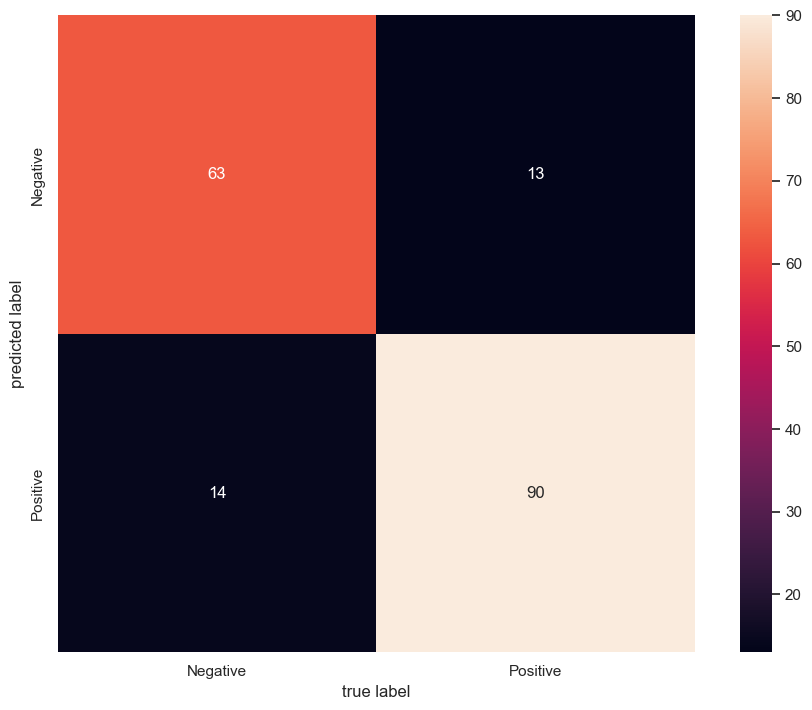


	~~~~	 BaggingClassifier 	~~~~

Cross-Validation Accuracy Scores: [0.82638889 0.85416667 0.86111111 0.84722222 0.83916084]
Mean Cross-Validation Accuracy: 0.8456099456099455
Standard Deviation of Cross-Validation Accuracy: 0.012059378412484948
Accuracy: 0.8388888888888889
Precision: 0.8627450980392157
Recall: 0.8543689320388349
F1 Score: 0.8585365853658536
ROC AUC Score: 0.8362753751103265 

              precision    recall  f1-score   support

    Negative       0.81      0.82      0.81        77
    Positive       0.86      0.85      0.86       103

    accuracy                           0.84       180
   macro avg       0.84      0.84      0.84       180
weighted avg       0.84      0.84      0.84       180

Positive Recall: 0.8543689320388349


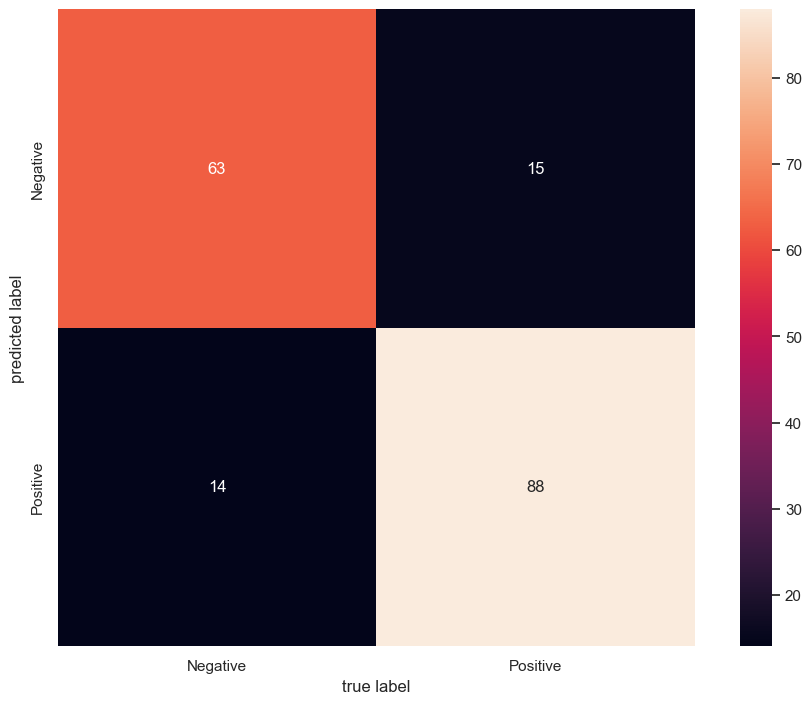

In [42]:
def split_data(data, test_size=0.2):
  X = data.drop(data.columns[-1], axis=1)
  y = data[data.columns[-1]]
  
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
  return X_train, X_test, y_train, y_test

def evaluate_model(y_test, y_pred, labels):
  accuracy = accuracy_score(y_test, y_pred)
  precision = precision_score(y_test, y_pred)
  recall = recall_score(y_test, y_pred)
  f1 = f1_score(y_test, y_pred)
  roc_auc = roc_auc_score(y_test, y_pred)

  print("Accuracy:", accuracy)
  print("Precision:", precision)
  print("Recall:", recall)
  print("F1 Score:", f1)
  print("ROC AUC Score:", roc_auc, '\n')

  cr = classification_report(y_test, y_pred, target_names=labels, zero_division=0)
  print(cr)
  
  cm = confusion_matrix(y_test, y_pred)

  true_positives = cm[1, 1]
  false_negatives = cm[1, 0]
  positive_recall = true_positives / (true_positives + false_negatives)
  print('Positive Recall:', positive_recall)
  
  sns.heatmap(cm.T, square=True, annot=True, fmt='d', xticklabels = labels, yticklabels = labels)
  plt.xlabel('true label')
  plt.ylabel('predicted label')
  plt.show()

def cross_vall_eval(model, X_train, y_train):
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')

    print("Cross-Validation Accuracy Scores:", scores)
    print("Mean Cross-Validation Accuracy:", scores.mean())
    print("Standard Deviation of Cross-Validation Accuracy:", scores.std())

# Implementing function for evaluation
def evaluate_models(data, models):
    # Preprocessing and Standardization
  X_train, X_test, y_train, y_test = split_data(data)

  for model in models:
    print('\n\t~~~~\t', type(model).__name__, '\t~~~~\n')
    # Train the model
    model.fit(X_train, y_train)

    # Measure Model 
    y_pred = model.predict(X_test)

    # Evaluate the model's performance
    cross_vall_eval(model, X_train, y_train)
    evaluate_model(y_test, y_pred, ['Negative', 'Positive'])

# Creating SVM and Bagging models
svm_model = SVC(kernel='linear')
bagging_svm_model = BaggingClassifier(base_estimator=svm_model)

# Evaluating SVM and Bagging models
evaluate_models(scaled_data, [svm_model, bagging_svm_model])


Build a Decision Tree Classifier model and a Bagging model:


	~~~~	 DecisionTreeClassifier 	~~~~

Cross-Validation Accuracy Scores: [0.81944444 0.78472222 0.77777778 0.8125     0.79020979]
Mean Cross-Validation Accuracy: 0.7969308469308469
Standard Deviation of Cross-Validation Accuracy: 0.016188414246002814
Accuracy: 0.8055555555555556
Precision: 0.831858407079646
Recall: 0.8545454545454545
F1 Score: 0.8430493273542601
ROC AUC Score: 0.7915584415584416 

              precision    recall  f1-score   support

    Negative       0.76      0.73      0.74        70
    Positive       0.83      0.85      0.84       110

    accuracy                           0.81       180
   macro avg       0.80      0.79      0.79       180
weighted avg       0.80      0.81      0.80       180

Positive Recall: 0.8545454545454545


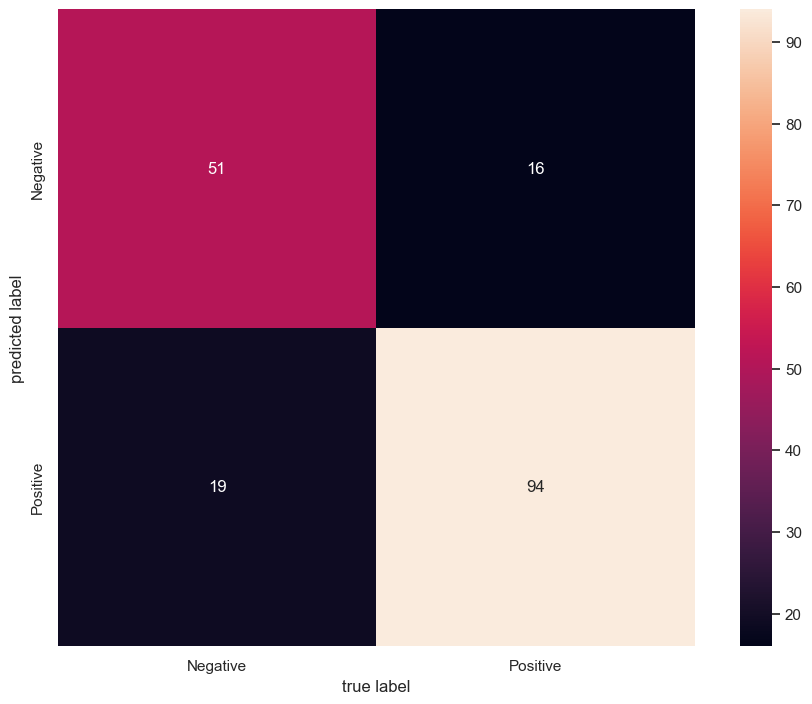


	~~~~	 BaggingClassifier 	~~~~

Cross-Validation Accuracy Scores: [0.83333333 0.86111111 0.83333333 0.85416667 0.81118881]
Mean Cross-Validation Accuracy: 0.8386266511266511
Standard Deviation of Cross-Validation Accuracy: 0.017640388378680007
Accuracy: 0.8611111111111112
Precision: 0.897196261682243
Recall: 0.8727272727272727
F1 Score: 0.8847926267281107
ROC AUC Score: 0.8577922077922078 

              precision    recall  f1-score   support

    Negative       0.81      0.84      0.83        70
    Positive       0.90      0.87      0.88       110

    accuracy                           0.86       180
   macro avg       0.85      0.86      0.85       180
weighted avg       0.86      0.86      0.86       180

Positive Recall: 0.8727272727272727


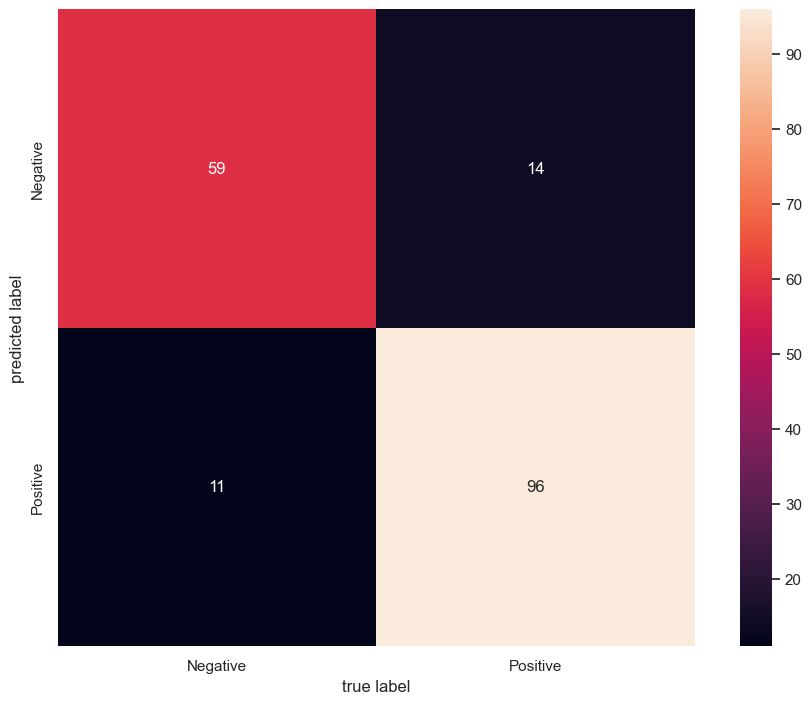

In [43]:


# Creating Decision Tree and Bagging models
dt_model = DecisionTreeClassifier()
bagging_dt_model = BaggingClassifier(base_estimator=dt_model)

# Evaluating Decision Tree and Bagging models
evaluate_models(scaled_data, [dt_model, bagging_dt_model])


Comparing the performance of SVM and Decision Tree Classifier, we can observe that both models have their strengths and weaknesses:

1. SVM (Support Vector Machine):
   - SVM is effective when dealing with high-dimensional datasets and non-linear decision boundaries.
   - It works well with complex patterns and is less prone to overfitting.
   - SVM tries to maximize the margin between classes, making it robust to noisy data.
   - However, SVM can be computationally expensive, especially with large datasets.

2. Decision Tree Classifier:
   - Decision Tree is simple to understand and interpret, making it suitable for visualization.
   - It can handle both numerical and categorical data and does not require feature scaling.
   - Decision Trees can capture complex interactions between features.
   - However, Decision Trees tend to overfit the data, especially when the tree depth is large.

Where it makes most sense to use bagging and why:<br>

Bagging is particularly useful when dealing with models that have high variance and are prone to overfitting, such as the Decision Tree Classifier. By combining multiple Decision Trees through Bagging, we can improve the model's generalization and reduce overfitting.<br>

In the case of SVM, which is already less prone to overfitting, applying Bagging may not bring significant improvements. SVM already tries to find the optimal margin between classes, so ensembling multiple SVM models through Bagging may not offer substantial benefits.<br>

Therefore, it makes the most sense to use Bagging with the Decision Tree Classifier. By aggregating the predictions of multiple Decision Trees, Bagging helps in reducing the variance and producing a more robust and accurate model. This ensemble approach enhances the model's ability to capture complex patterns and interactions in the data, leading to improved performance and better generalization.